In [1]:
import pandas as pd
import numpy as np
import glob
import soundfile
import os
import sys


import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

from IPython.display import Audio


import keras
from keras.utils import plot_model



import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

Using TensorFlow backend.


In [2]:
Ravdess = "C:\\Users\\yuthi\\Downloads\\speech-emotion-recognition-ravdess-data\\"

In [3]:
import os
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    
    Actor = os.listdir(Ravdess + dir)
    for file in Actor:
        part = file.split('.')[0]
        part = part.split('-')
   
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)


Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotions,Path
0,neutral,C:\Users\yuthi\Downloads\speech-emotion-recogn...
1,neutral,C:\Users\yuthi\Downloads\speech-emotion-recogn...
2,neutral,C:\Users\yuthi\Downloads\speech-emotion-recogn...
3,neutral,C:\Users\yuthi\Downloads\speech-emotion-recogn...
4,calm,C:\Users\yuthi\Downloads\speech-emotion-recogn...


In [4]:
datapath= pd.concat([Ravdess_df], axis=0)
datapath.to_csv("data_path.csv", index= False)
datapath.head()

,Emotions,Path
0,neutral,C:\Users\yuthi\Downloads\speech-emotion-recogn...
1,neutral,C:\Users\yuthi\Downloads\speech-emotion-recogn...
2,neutral,C:\Users\yuthi\Downloads\speech-emotion-recogn...
3,neutral,C:\Users\yuthi\Downloads\speech-emotion-recogn...
4,calm,C:\Users\yuthi\Downloads\speech-emotion-recogn...


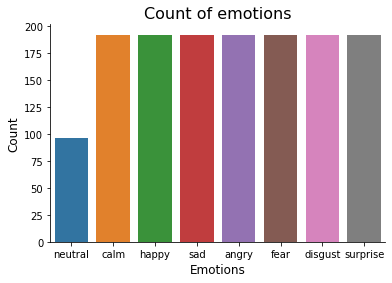

In [5]:
plt.title('Count of emotions', size=16)
sns.countplot(datapath.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [6]:
def createWaveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

In [7]:
def createSpectogram(data, sr, e):
    X=librosa.stft(data)
    Xdb=librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12,3))
    plt.title('Spectogram with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb,sr=sr, y_axis='hz', x_axis='time')
    plt.colorbar()

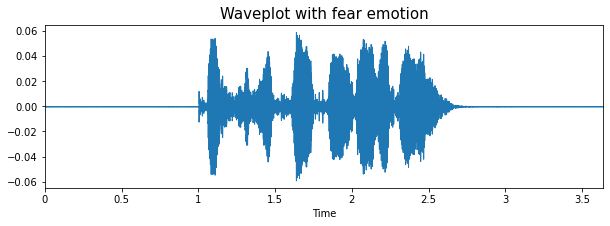

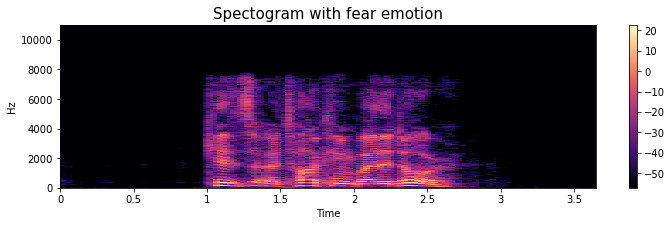

In [8]:
emotion='fear'
path=np.array(datapath.Path[datapath.Emotions==emotion])[1]
data , samplingRate= librosa.load(path)
createWaveplot(data, samplingRate, emotion)
createSpectogram(data, samplingRate, emotion)
Audio(path)

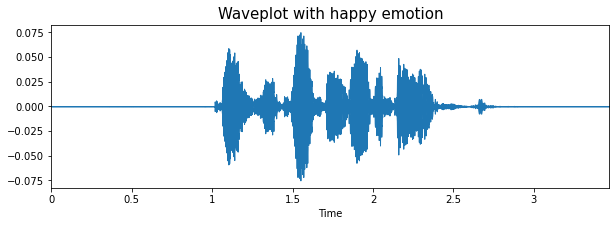

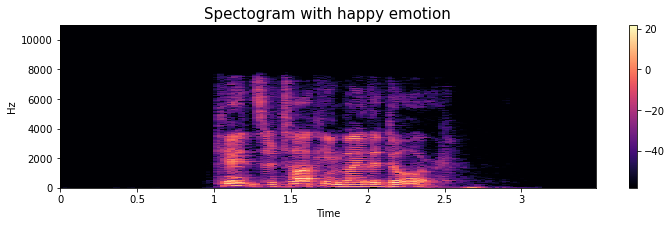

In [9]:
emotion='happy'
path=np.array(datapath.Path[datapath.Emotions==emotion])[1]
data , samplingRate= librosa.load(path)
createWaveplot(data, samplingRate, emotion)
createSpectogram(data, samplingRate, emotion)
Audio(path)

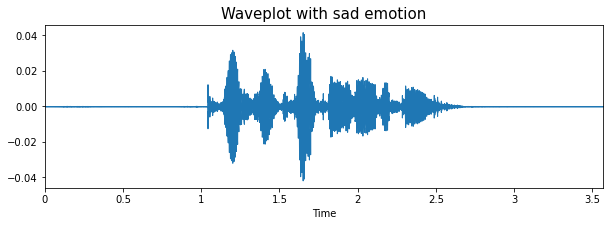

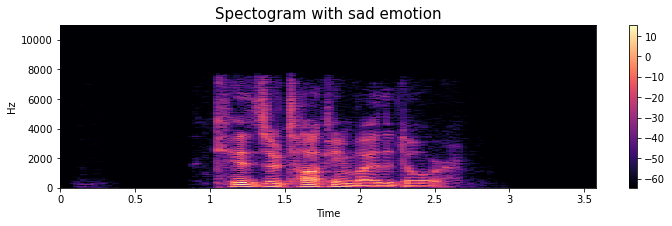

In [10]:
emotion='sad'
path=np.array(datapath.Path[datapath.Emotions==emotion])[1]
data , samplingRate= librosa.load(path)
createWaveplot(data, samplingRate, emotion)
createSpectogram(data, samplingRate, emotion)
Audio(path)

In [11]:
def noise(data):
    noiseAmp=0.035*np.random.uniform()*np.amax(data)
    data= data+ noiseAmp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shiftRange=int(np.random.uniform(low=-5, high=5)*1000)
    return np.roll(data, shiftRange)

def pitch(data, samplingRate, pitchFactor=0.7):
    return librosa.effects.pitch_shift(data, samplingRate, pitchFactor)


In [12]:
path=np.array(datapath.Path)[1]
data , sampleRate= librosa.load(path)

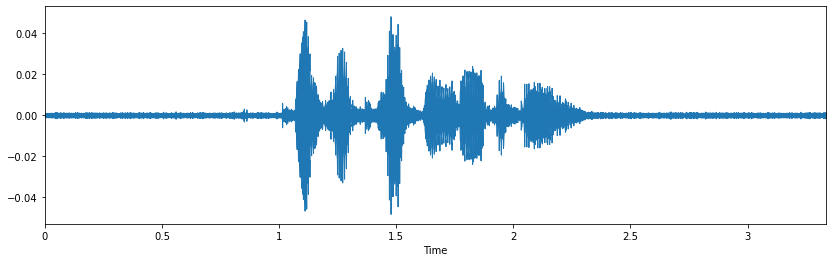

In [13]:
x=noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x,sr=sampleRate)
Audio(x,rate=sampleRate)

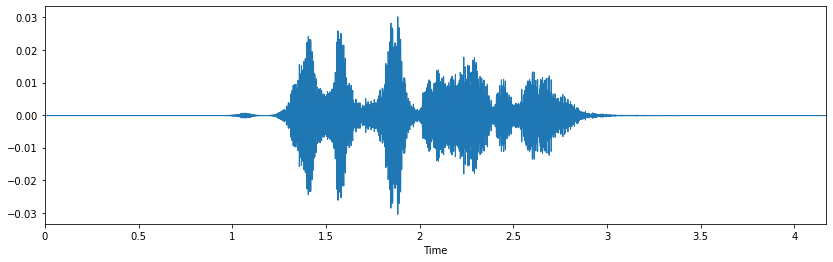

In [14]:
x=stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x,sr=sampleRate)
Audio(x,rate=sampleRate)

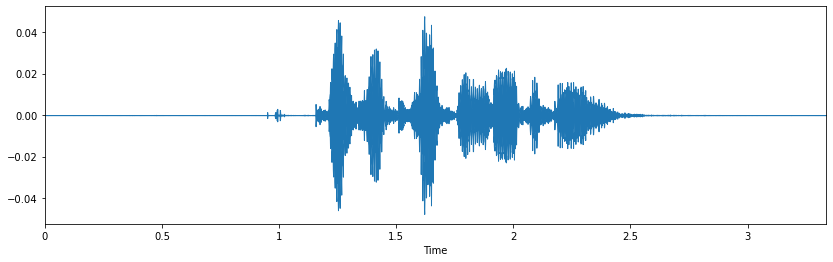

In [15]:
x=shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x,sr=sampleRate)
Audio(x,rate=sampleRate)

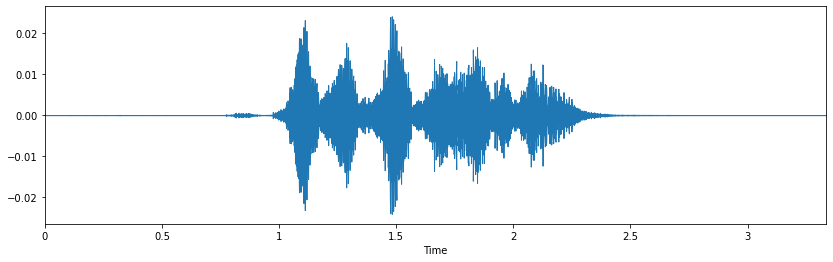

In [16]:
x=pitch(data,sampleRate)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x,sr=sampleRate)
Audio(x,rate=sampleRate)

In [17]:
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD
from keras.regularizers import l2
import seaborn as sns
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
from sklearn.metrics import classification_report

In [18]:
def extractFeature(fileName, mfcc, chroma, mel):
    with soundfile.SoundFile(fileName) as soundFile:
        X=soundFile.read(dtype="float32")
        sampleRate=soundFile.samplerate
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sampleRate, n_mfcc=40).T, axis=0)
            result=np.hstack((result,mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sampleRate).T, axis=0)
            result=np.hstack((result,chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sampleRate).T, axis=0)
            result=np.hstack((result,mel))
    return result

In [19]:
emotions={
    '01':'neutral',
    '02':'calm',
    '03':'happy',
    '04':'sad',
    '05':'angry',
    '06':'fearful',
    '07':'disgust',
    '08':'surprised',
}
observedEmotions=['calm','happy','fearful','disgust']

In [20]:
def loadData(test_size=0.2):
    x,y=[],[]
    for file in glob.glob("C:\\Users\\yuthi\\Downloads\\speech-emotion-recognition-ravdess-data\\Actor_*\\*.wav"):
       fileName=os.path.basename(file)
       emotion1=emotions[fileName.split("-")[2]]
       if emotion1 not in observedEmotions:
        continue
       feature=extractFeature(file, mfcc=True, chroma=True, mel=True)
       x.append(feature)
       y.append(emotion1)
    return train_test_split(np.array(x),y, test_size=test_size, random_state=9)

In [21]:
xTrain,xTest,yTrain,yTest=loadData(test_size=0.50)

In [22]:
print((xTrain.shape[0], xTest.shape[0]))

(384, 384)


In [23]:
print(f'no.of Features extracted: {xTrain.shape[1]}')

no.of Features extracted: 180


In [24]:
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [25]:
model.fit(xTrain,yTrain)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [26]:
expectedofY=yTest
yPred=model.predict(xTest)

In [27]:
import sklearn.metrics as metrics
print(metrics.confusion_matrix(expectedofY,yPred))

[[87 10  6  4]
 [ 8 68  9 11]
 [ 2  4 65 12]
 [ 8  8 18 64]]


In [28]:
print(classification_report(yTest,yPred))

              precision    recall  f1-score   support

        calm       0.83      0.81      0.82       107
     disgust       0.76      0.71      0.73        96
     fearful       0.66      0.78      0.72        83
       happy       0.70      0.65      0.68        98

    accuracy                           0.74       384
   macro avg       0.74      0.74      0.74       384
weighted avg       0.74      0.74      0.74       384



In [29]:
accuracy=accuracy_score(y_true=yTest, y_pred=yPred)

print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 73.96%
